In [1]:
import pandas as pd
import numpy as np
import pickle
import random

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, ShuffleSplit, cross_val_score, learning_curve
from sklearn.model_selection import KFold, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb, lightgbm as lgbm, catboost as catb

import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

### Обзор данных<a class="anchor" id="course_project_review"></a>

**Описание датасета**

* **Home Ownership** - домовладение
* **Annual Income** - годовой доход
* **Years in current job** - количество лет на текущем месте работы
* **Tax Liens** - налоговые обременения
* **Number of Open Accounts** - количество открытых счетов
* **Years of Credit History** - количество лет кредитной истории
* **Maximum Open Credit** - наибольший открытый кредит
* **Number of Credit Problems** - количество проблем с кредитом
* **Months since last delinquent** - количество месяцев с последней просрочки платежа
* **Bankruptcies** - банкротства
* **Purpose** - цель кредита
* **Term** - срок кредита
* **Current Loan Amount** - текущая сумма кредита
* **Current Credit Balance** - текущий кредитный баланс
* **Monthly Debt** - ежемесячный долг
* **Credit Default** - факт невыполнения кредитных обязательств (0 - погашен вовремя, 1 - просрочка)

#### Пути к директориям и файлам

In [2]:
TRAIN_DATASET_PATH = 'course_project_train.csv'
TEST_DATASET_PATH = 'course_project_test.csv'

**Загрузка данных**

In [3]:
df_train = pd.read_csv(TRAIN_DATASET_PATH)
df_train.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,Own Home,482087.0,NaN,0.0,11.0,26.3,685960.0,1.0,NaN,1.0,debt consolidation,Short Term,99999999.0,47386.0,7914.0,749.0,0
1,Own Home,1025487.0,10+ years,0.0,15.0,15.3,1181730.0,0.0,NaN,0.0,debt consolidation,Long Term,264968.0,394972.0,18373.0,737.0,1
2,Home Mortgage,751412.0,8 years,0.0,11.0,35.0,1182434.0,0.0,NaN,0.0,debt consolidation,Short Term,99999999.0,308389.0,13651.0,742.0,0
3,Own Home,805068.0,6 years,0.0,8.0,22.5,147400.0,1.0,NaN,1.0,debt consolidation,Short Term,121396.0,95855.0,11338.0,694.0,0
4,Rent,776264.0,8 years,0.0,13.0,13.6,385836.0,1.0,NaN,0.0,debt consolidation,Short Term,125840.0,93309.0,7180.0,719.0,0


In [4]:
df_train.shape

(7500, 17)

In [5]:
df_train.iloc[0]

Home Ownership                            Own Home
Annual Income                               482087
Years in current job                           NaN
Tax Liens                                        0
Number of Open Accounts                         11
Years of Credit History                       26.3
Maximum Open Credit                         685960
Number of Credit Problems                        1
Months since last delinquent                   NaN
Bankruptcies                                     1
Purpose                         debt consolidation
Term                                    Short Term
Current Loan Amount                          1e+08
Current Credit Balance                       47386
Monthly Debt                                  7914
Credit Score                                   749
Credit Default                                   0
Name: 0, dtype: object

In [6]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                7500 non-null   object 
 1   Annual Income                 5943 non-null   float64
 2   Years in current job          7129 non-null   object 
 3   Tax Liens                     7500 non-null   float64
 4   Number of Open Accounts       7500 non-null   float64
 5   Years of Credit History       7500 non-null   float64
 6   Maximum Open Credit           7500 non-null   float64
 7   Number of Credit Problems     7500 non-null   float64
 8   Months since last delinquent  3419 non-null   float64
 9   Bankruptcies                  7486 non-null   float64
 10  Purpose                       7500 non-null   object 
 11  Term                          7500 non-null   object 
 12  Current Loan Amount           7500 non-null   float64
 13  Cur

In [7]:
df_train.describe()

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
count,5.943000e+03,7500.000000,7500.000000,7500.000000,7.500000e+03,7500.000000,3419.000000,7486.000000,7.500000e+03,7.500000e+03,7500.000000,5943.000000,7500.000000
mean,1.366392e+06,0.030133,11.130933,18.317467,9.451537e+05,0.170000,34.692600,0.117152,1.187318e+07,2.898332e+05,18314.454133,1151.087498,0.281733
std,8.453392e+05,0.271604,4.908924,7.041946,1.602622e+07,0.498598,21.688806,0.347192,3.192612e+07,3.178714e+05,11926.764673,1604.451418,0.449874
min,1.645970e+05,0.000000,2.000000,4.000000,0.000000e+00,0.000000,0.000000,0.000000,1.124200e+04,0.000000e+00,0.000000,585.000000,0.000000
25%,8.443410e+05,0.000000,8.000000,13.500000,2.792295e+05,0.000000,16.000000,0.000000,1.801690e+05,1.142565e+05,10067.500000,711.000000,0.000000
50%,1.168386e+06,0.000000,10.000000,17.000000,4.781590e+05,0.000000,32.000000,0.000000,3.095730e+05,2.093230e+05,16076.500000,731.000000,0.000000
75%,1.640137e+06,0.000000,14.000000,21.800000,7.935015e+05,0.000000,50.000000,0.000000,5.198820e+05,3.604062e+05,23818.000000,743.000000,1.000000
max,1.014934e+07,7.000000,43.000000,57.700000,1.304726e+09,7.000000,118.000000,4.000000,1.000000e+08,6.506797e+06,136679.000000,7510.000000,1.000000


### Анализ целевой переменной<a class="anchor" id="target_analysis"></a>

In [8]:
df_train['Credit Default'].value_counts()

0    5387
1    2113
Name: Credit Default, dtype: int64

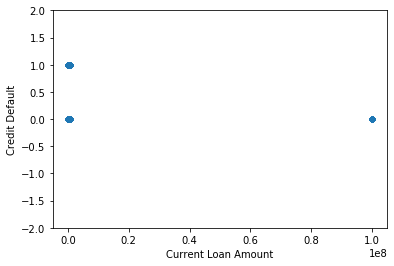

In [11]:
var = 'Current Loan Amount'
data = pd.concat([df_train['Credit Default'], df_train[var]], axis=1)
data.plot.scatter(x=var, y='Credit Default', ylim=(-2,2));

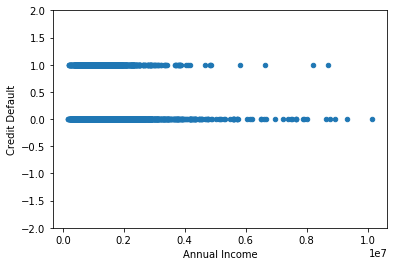

In [12]:
var = 'Annual Income'
data = pd.concat([df_train['Credit Default'], df_train[var]], axis=1)
data.plot.scatter(x=var, y='Credit Default', ylim=(-2,2));

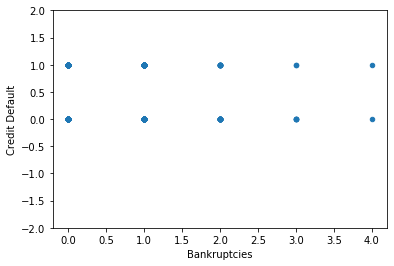

In [13]:
var = 'Bankruptcies'
data = pd.concat([df_train['Credit Default'], df_train[var]], axis=1)
data.plot.scatter(x=var, y='Credit Default', ylim=(-2,2));

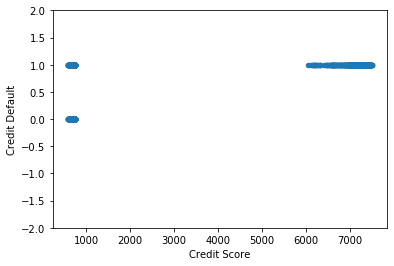

In [14]:
var = 'Credit Score'
data = pd.concat([df_train['Credit Default'], df_train[var]], axis=1)
data.plot.scatter(x=var, y='Credit Default', ylim=(-2,2));

**Выделение целевой переменной и групп признаков**

In [15]:
TARGET_NAME = 'Credit Default'
BASE_FEATURE_NAMES = df_train.columns.drop(TARGET_NAME).tolist()
NEW_FEATURE_NAMES = df_train.columns.drop([TARGET_NAME] + BASE_FEATURE_NAMES)

In [16]:
df_train[TARGET_NAME].value_counts()

0    5387
1    2113
Name: Credit Default, dtype: int64

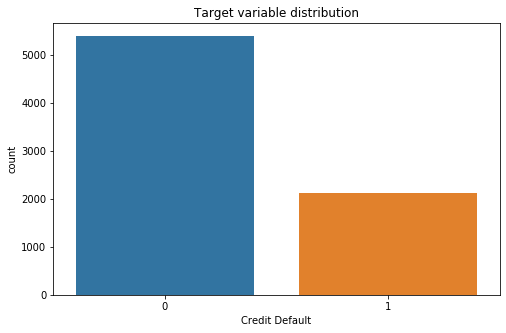

In [17]:
plt.figure(figsize=(8, 5))

sns.countplot(x=TARGET_NAME, data=df_train)

plt.title('Target variable distribution')
plt.show()

**Корреляция с базовыми признаками**

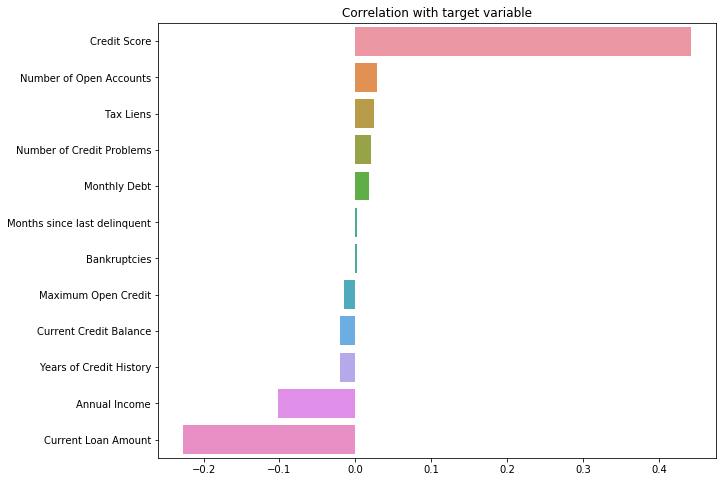

In [18]:
corr_with_target = df_train[BASE_FEATURE_NAMES + [TARGET_NAME]].corr().iloc[:-1, -1].sort_values(ascending=False)

plt.figure(figsize=(10, 8))

sns.barplot(x=corr_with_target.values, y=corr_with_target.index)

plt.title('Correlation with target variable')
plt.show()

### Анализ признакового пространства<a class="anchor" id="features_analysis"></a>

**Матрица корреляций**

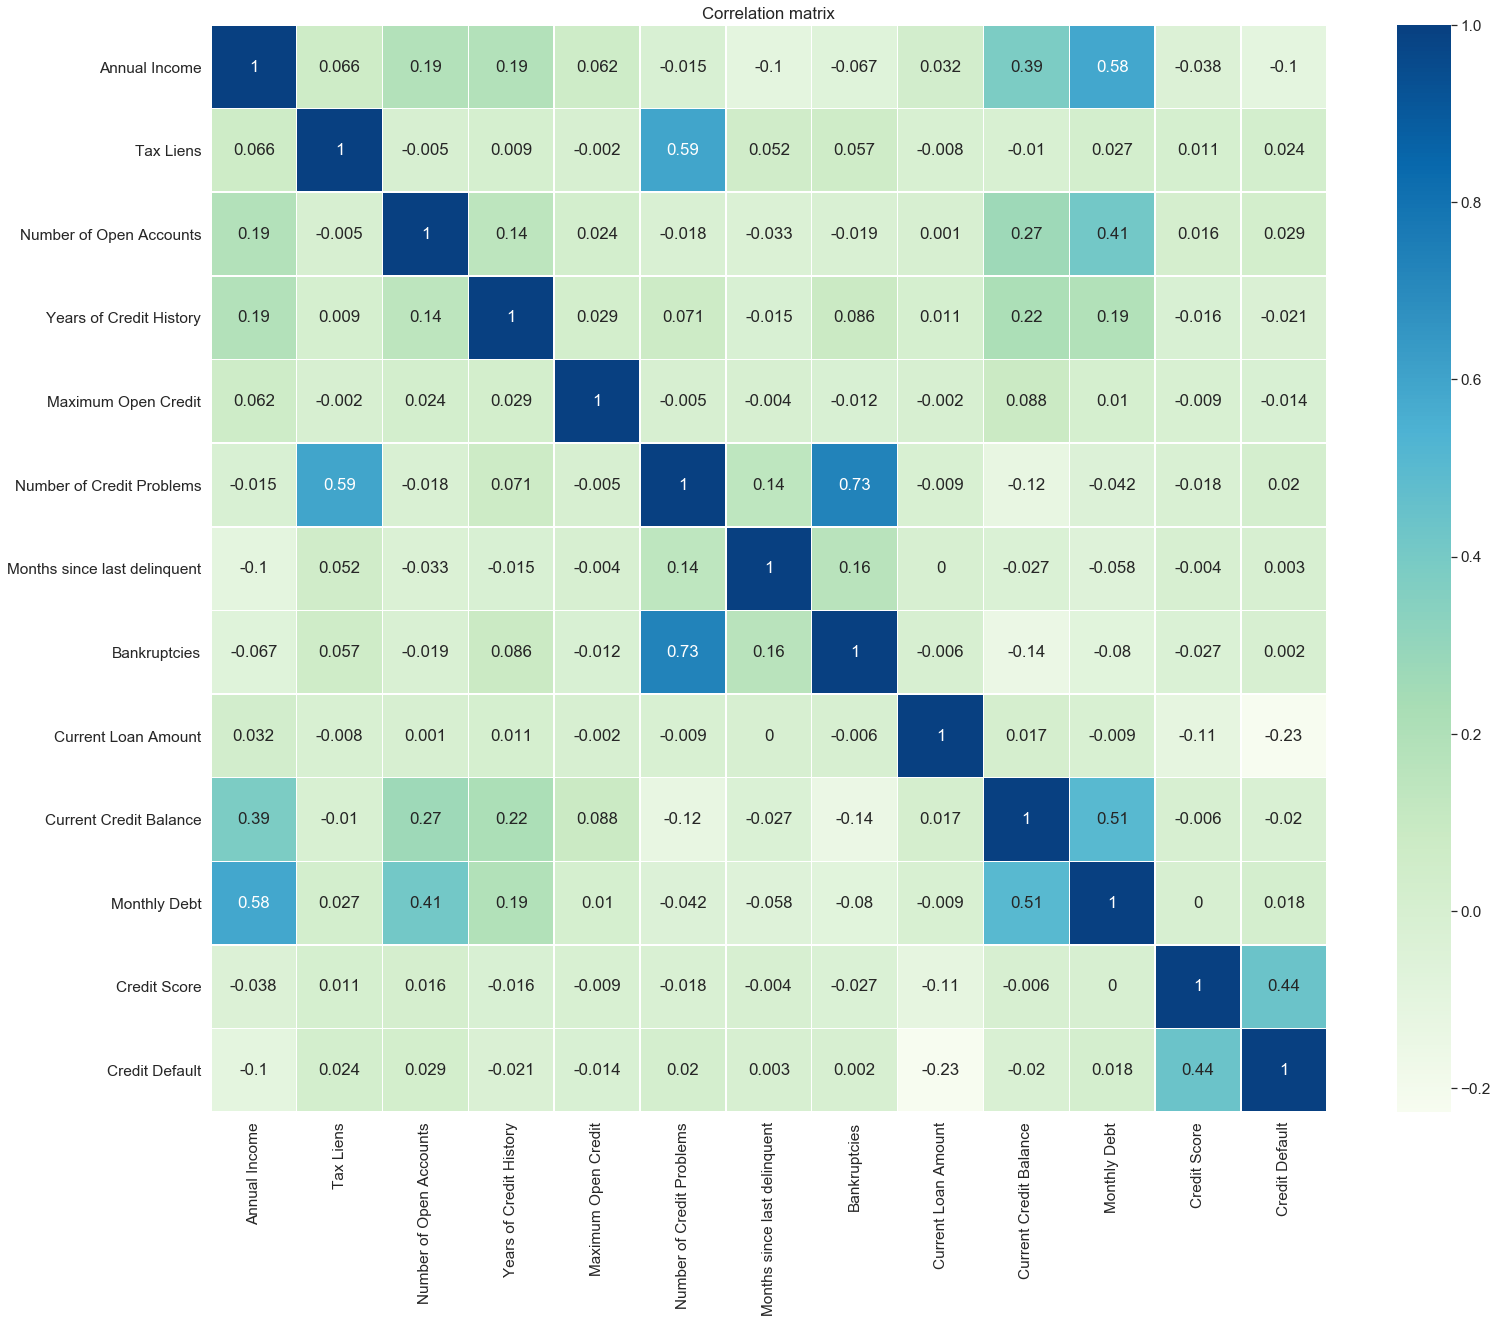

In [19]:
plt.figure(figsize = (25,20))

sns.set(font_scale=1.4)
sns.heatmap(df_train[BASE_FEATURE_NAMES + [TARGET_NAME]].corr().round(3), annot=True, linewidths=.5, cmap='GnBu')

plt.title('Correlation matrix')
plt.show()

### Обработка выбросов и пропусков<a class="anchor" id="features_analysis"></a>

**Класс обработки**

In [20]:
class FeatureImputer:
    """Заполнение пропусков и обработка выбросов"""
    
    def __init__(self):
        self.medians=None
        
    def fit(self, X):
        self.medians = X.median()
    
    def transform(self, X):
        X['Purpose_1'] = X['Purpose'].isin(['medical bills']) * 1
        X['Purpose_2'] = X['Purpose'].isin(['buy a car']) * 1
        X['Purpose_3'] = X['Purpose'].isin(['home improvements']) * 1
        X['Purpose_4'] = X['Purpose'].isin(['buy house']) * 1
        X['Purpose_5'] = X['Purpose'].isin(['major purchase']) * 1
        X['Purpose_6'] = X['Purpose'].isin(['other']) * 1
        X['Purpose_7'] = X['Purpose'].isin(['wedding']) * 1
        X['Purpose_8'] = X['Purpose'].isin(['small business']) * 1
        X['Purpose_9'] = X['Purpose'].isin(['renewable energy']) * 1
        X['Purpose_10'] = X['Purpose'].isin(['educational expenses']) * 1
        X['Purpose_11'] = X['Purpose'].isin(['business loan']) * 1
        X['Purpose_12'] = X['Purpose'].isin(['take a trip']) * 1
        X['Purpose_13'] = X['Purpose'].isin(['vacation']) * 1
        X['Purpose_14'] = X['Purpose'].isin(['moving']) * 1
        X['Purpose_15'] = X['Purpose'].isin(['debt consolidation']) * 1
        
        X['Home_1'] = X['Home Ownership'].isin(['Home Mortgage'])*1
        X['Home_2'] = X['Home Ownership'].isin(['Have Mortgage'])*1
        X['Home_3'] = X['Home Ownership'].isin(['Rent'])*1
        X['Home_4'] = X['Home Ownership'].isin(['Own Home'])*1
        
        X['Term_val'] = X['Term'].isin(['Long Term'])*1

        
        X.loc[X['Years in current job'] == '9 years', 'Years in current job'] = 9
        X.loc[X['Years in current job'] == '7 years', 'Years in current job'] = 7
        X.loc[X['Years in current job'] == '6 years', 'Years in current job'] = 6
        X.loc[X['Years in current job'] == '4 years', 'Years in current job'] = 4
        X.loc[X['Years in current job'] == '8 years', 'Years in current job'] = 8
        X.loc[X['Years in current job'] == '1 year', 'Years in current job'] = 1
        X.loc[X['Years in current job'] == '5 years', 'Years in current job'] = 5
        X.loc[X['Years in current job'] == '10+ years', 'Years in current job'] = 10
        X.loc[X['Years in current job'] == '3 years', 'Years in current job'] = 3
        X.loc[X['Years in current job'] == '2 years', 'Years in current job'] = 2
        X.loc[X['Years in current job'] == '< 1 year', 'Years in current job'] = 0.5
        X['Years in current job'] = X['Years in current job'].apply(pd.to_numeric, errors='coerce')
        X.loc[X['Years in current job'].isna()*1 == 1, 'Years in current job'] = self.medians['Years in current job']
        
        X.loc[X['Credit Score'].isna(), 'Credit Score'] = self.medians['Credit Score']

        
        X.loc[X['Annual Income'].isna(), 'Annual Income'] = self.medians['Annual Income']
        
        X.loc[X['Bankruptcies'].isna(), 'Bankruptcies'] = self.medians['Bankruptcies']
        
        X.loc[X['Current Loan Amount'] > 1000000, 'Current Loan Amount'] = self.medians['Current Loan Amount']
        
        X.loc[X['Months since last delinquent'].isna(), 'Months since last delinquent'] = 0

        return X


**Обработка матрицы**

In [21]:
X = []

In [23]:
imputer = FeatureImputer()

imputer.fit(df_train)
X = imputer.transform(df_train)


C:\Users\Noyanlar\anaconda3\lib\site-packages\pandas\core\ops\array_ops.py:253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  res_values = method(rvalues)


### Анализ обработанной матрицы<a class="anchor" id="features_analysis"></a>

**Выделение целевой переменной и групп признаков**

In [24]:
TARGET_NAME = 'Credit Default'
BASE_FEATURE_NAMES = X.columns.drop(TARGET_NAME).tolist()
NEW_FEATURE_NAMES = X.columns.drop([TARGET_NAME] + BASE_FEATURE_NAMES)

**Корреляция с базовыми признаками**

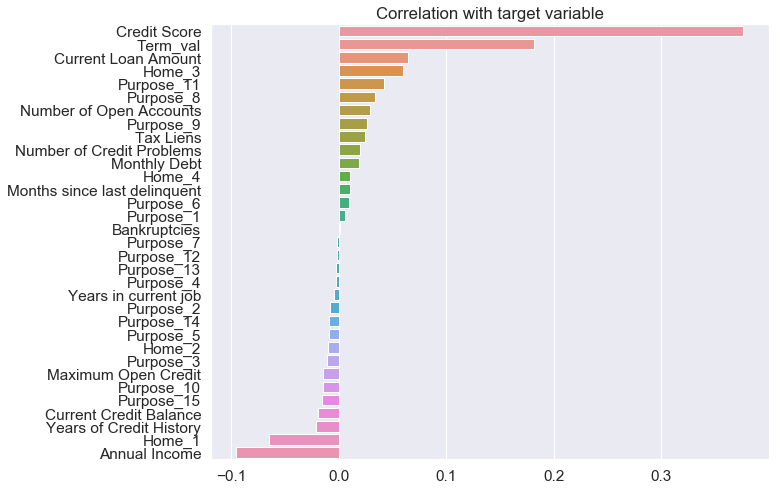

In [25]:
corr_with_target = X[BASE_FEATURE_NAMES + [TARGET_NAME]].corr().iloc[:-1, -1].sort_values(ascending=False)

plt.figure(figsize=(10, 8))

sns.barplot(x=corr_with_target.values, y=corr_with_target.index)

plt.title('Correlation with target variable')
plt.show()

**Матрица корреляций**

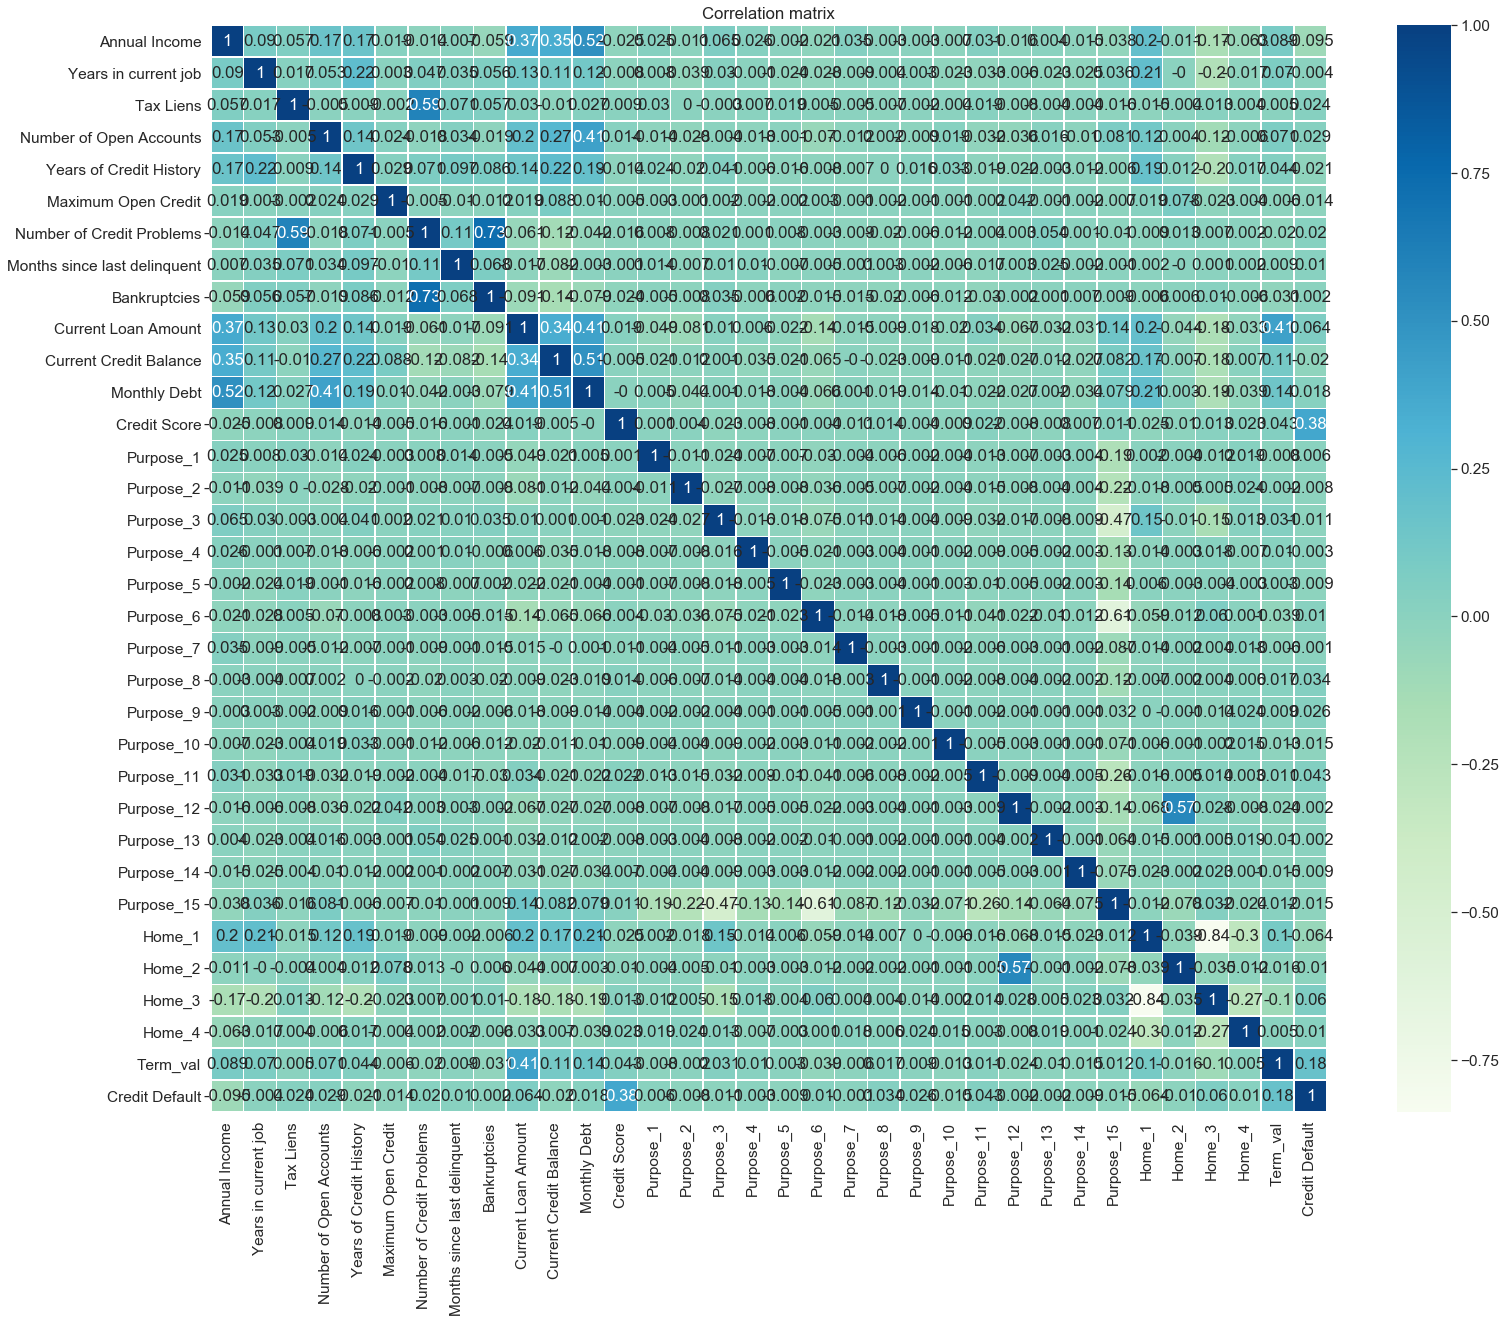

In [26]:
plt.figure(figsize = (25,20))

sns.set(font_scale=1.4)
sns.heatmap(X[BASE_FEATURE_NAMES + [TARGET_NAME]].corr().round(3), annot=True, linewidths=.5, cmap='GnBu')

plt.title('Correlation matrix')
plt.show()

### Отбор признаков<a class="anchor" id="features_analysis"></a>

In [27]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 37 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                7500 non-null   object 
 1   Annual Income                 7500 non-null   float64
 2   Years in current job          7500 non-null   float64
 3   Tax Liens                     7500 non-null   float64
 4   Number of Open Accounts       7500 non-null   float64
 5   Years of Credit History       7500 non-null   float64
 6   Maximum Open Credit           7500 non-null   float64
 7   Number of Credit Problems     7500 non-null   float64
 8   Months since last delinquent  7500 non-null   float64
 9   Bankruptcies                  7500 non-null   float64
 10  Purpose                       7500 non-null   object 
 11  Term                          7500 non-null   object 
 12  Current Loan Amount           7500 non-null   float64
 13  Cur

**Выделение признакового описания и целевой переменной**

In [28]:
NUMERIC_FEATURE_NAMES = ['Annual Income', 'Years in current job', 'Tax Liens', 'Number of Open Accounts', 
                         'Number of Credit Problems', 'Years of Credit History',
                        'Maximum Open Credit', 'Current Loan Amount', 'Months since last delinquent',
                         'Current Credit Balance', 'Bankruptcies','Monthly Debt', 'Credit Score']
BIN_FEATURE_NAMES = ['Purpose_1', 'Purpose_2', 'Purpose_3', 'Purpose_4', 'Purpose_5', 'Purpose_6', 'Purpose_7', 'Purpose_8',
                    'Purpose_9', 'Purpose_10', 'Purpose_11', 'Purpose_12', 'Purpose_13', 'Purpose_14', 'Purpose_15', 
                     'Home_1', 'Home_2', 'Home_3', 'Home_4', 'Term_val']


### Разбиение на train и test<a class="anchor" id="train_and_test"></a>

In [29]:
X_t = X[NUMERIC_FEATURE_NAMES + BIN_FEATURE_NAMES]
y_t = X[TARGET_NAME]

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X_t, y_t, shuffle=True, test_size=0.25, random_state=211)

### Выбор лучшей модели и подбор гиперпараметров<a class="anchor" id="tuning_best_model"></a> 

**Скрипты для проверки модели**

In [31]:
def get_classification_report(y_train_true, y_train_pred, y_test_true, y_test_pred):
    print('TRAIN\n\n' + classification_report(y_train_true, y_train_pred))
    print('TEST\n\n' + classification_report(y_test_true, y_test_pred))
    print('CONFUSION MATRIX\n')
    print(pd.crosstab(y_test_true, y_test_pred))

In [32]:
def show_proba_calibration_plots(y_predicted_probs, y_true_labels):
    preds_with_true_labels = np.array(list(zip(y_predicted_probs, y_true_labels)))

    thresholds = []
    precisions = []
    recalls = []
    f1_scores = []

    for threshold in np.linspace(0.1, 0.9, 9):
        thresholds.append(threshold)
        precisions.append(precision_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        recalls.append(recall_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        f1_scores.append(f1_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))

    scores_table = pd.DataFrame({'f1':f1_scores,
                                 'precision':precisions,
                                 'recall':recalls,
                                 'probability':thresholds}).sort_values('f1', ascending=False).round(3)
  
    figure = plt.figure(figsize = (15, 5))

    plt1 = figure.add_subplot(121)
    plt1.plot(thresholds, precisions, label='Precision', linewidth=4)
    plt1.plot(thresholds, recalls, label='Recall', linewidth=4)
    plt1.plot(thresholds, f1_scores, label='F1', linewidth=4)
    plt1.set_ylabel('Scores')
    plt1.set_xlabel('Probability threshold')
    plt1.set_title('Probabilities threshold calibration')
    plt1.legend(bbox_to_anchor=(0.25, 0.25))   
    plt1.table(cellText = scores_table.values,
               colLabels = scores_table.columns, 
               colLoc = 'center', cellLoc = 'center', loc = 'bottom', bbox = [0, -1.3, 1, 1])

    plt2 = figure.add_subplot(122)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 0][:, 0], 
              label='Another class', color='royalblue', alpha=1)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 1][:, 0], 
              label='Main class', color='darkcyan', alpha=0.8)
    plt2.set_ylabel('Number of examples')
    plt2.set_xlabel('Probabilities')
    plt2.set_title('Probability histogram')
    plt2.legend(bbox_to_anchor=(1, 1))

    plt.show()

In [33]:
def show_learning_curve_plot(estimator, X, y, cv=3, n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):

    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, 
                                                            cv=cv, 
                                                            scoring='f1',
                                                            train_sizes=train_sizes, 
                                                            n_jobs=n_jobs)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.figure(figsize=(15,8))
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.title(f"Learning curves ({type(estimator).__name__})")
    plt.xlabel("Training examples")
    plt.ylabel("Score")     
    plt.legend(loc="best")
    plt.grid()
    plt.show()

In [34]:
def show_feature_importances(feature_names, feature_importances, get_top=None):
    feature_importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importances})
    feature_importances = feature_importances.sort_values('importance', ascending=False)
       
    plt.figure(figsize = (20, len(feature_importances) * 0.355))
    
    sns.barplot(feature_importances['importance'], feature_importances['feature'])
    
    plt.xlabel('Importance')
    plt.title('Importance of features')
    plt.show()
    
    if get_top is not None:
        return feature_importances['feature'][:get_top].tolist()

**Модель CatBoostClassifier**

In [38]:
model_catb = catb.CatBoostClassifier(silent=True, random_state=21)
model_catb.fit(X_train, y_train)

y_train_pred = model_catb.predict(X_train)
y_test_pred = model_catb.predict(X_test)
y_test_pred_probs = model_catb.predict_proba(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.85      1.00      0.92      4047
           1       0.99      0.54      0.70      1578

    accuracy                           0.87      5625
   macro avg       0.92      0.77      0.81      5625
weighted avg       0.89      0.87      0.86      5625

TEST

              precision    recall  f1-score   support

           0       0.78      0.97      0.86      1340
           1       0.81      0.30      0.44       535

    accuracy                           0.78      1875
   macro avg       0.79      0.64      0.65      1875
weighted avg       0.79      0.78      0.74      1875

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1302   38
1                372  163


### Подбор признаков<a class="anchor" id="learning_curve"></a>

**Подбор оптимального размера выборки, кривая обучения**

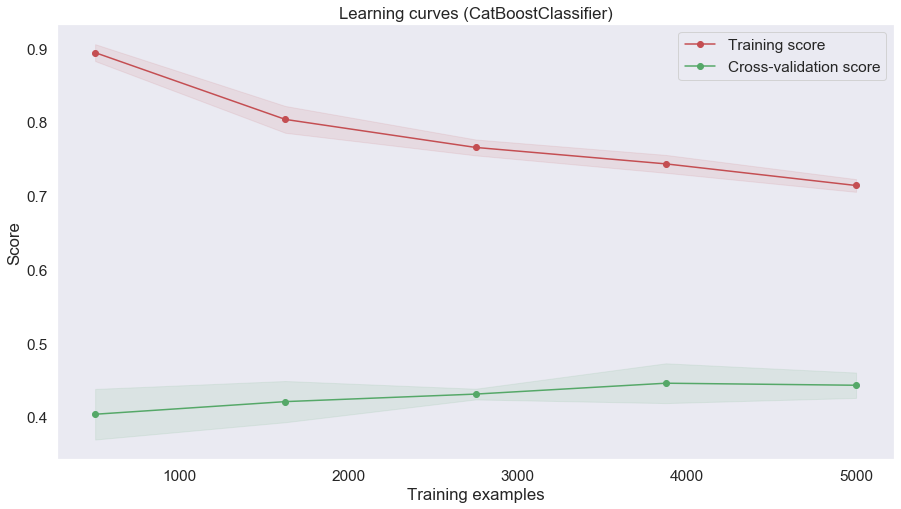

In [36]:
show_learning_curve_plot(model_catb, X_t, y_t)

**Выбор порога вероятности для определения класса**

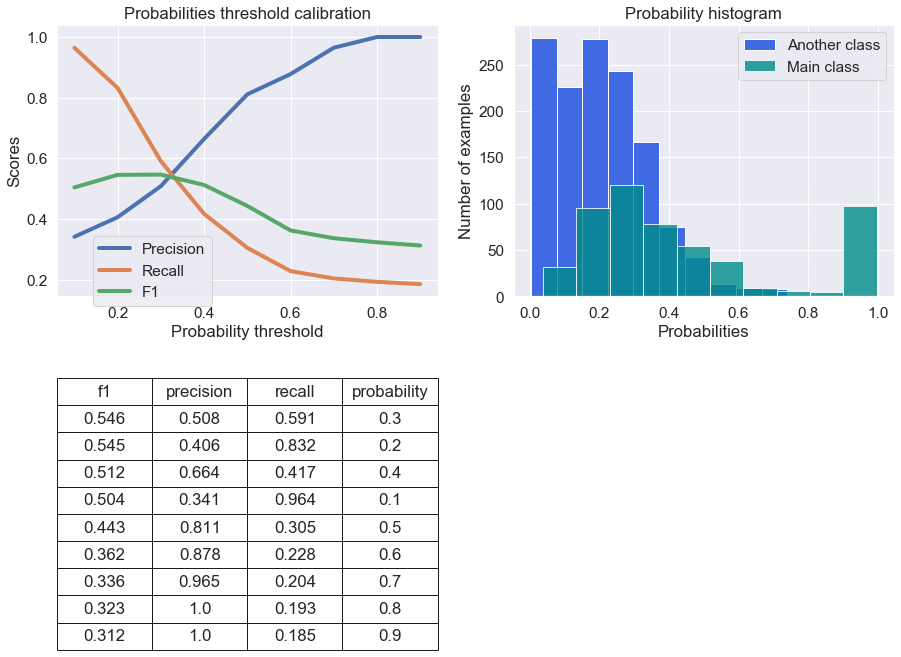

In [39]:
show_proba_calibration_plots(y_test_pred_probs[:, 1], y_test)

**Важность признаков**

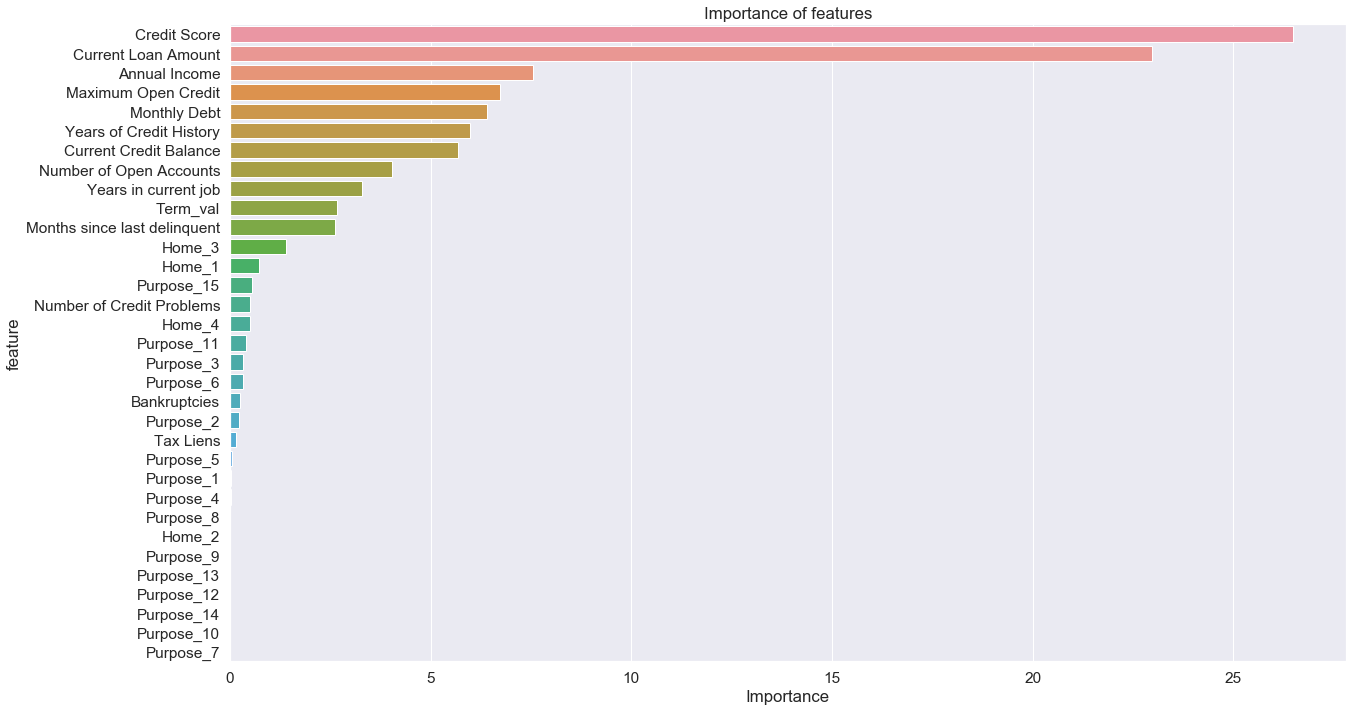

In [41]:
important_features_top = show_feature_importances(X_train.columns, model_catb.feature_importances_, get_top=15)

In [42]:
important_features_top

['Credit Score',
 'Current Loan Amount',
 'Annual Income',
 'Maximum Open Credit',
 'Monthly Debt',
 'Years of Credit History',
 'Current Credit Balance',
 'Number of Open Accounts',
 'Years in current job',
 'Term_val',
 'Months since last delinquent',
 'Home_3',
 'Home_1',
 'Purpose_15',
 'Number of Credit Problems']

In [43]:
NUMERIC_FEATURE_NAMES = ['Credit Score',
 'Current Loan Amount',
 'Months since last delinquent',
 'Annual Income',
 'Maximum Open Credit',
 'Monthly Debt',
 'Years of Credit History']

BIN_FEATURE_NAMES = ['Current Credit Balance',
 'Number of Open Accounts',
 'Term_val',
 'Number of Credit Problems',
 'Purpose_15',
 'Home_4',
 'Purpose_11']

**Разбиение на train и test**

In [44]:
X_t = X[NUMERIC_FEATURE_NAMES + BIN_FEATURE_NAMES]
y_t = X[TARGET_NAME]

In [45]:
X_train, X_test, y_train, y_test = train_test_split(X_t, y_t, shuffle=True, test_size=0.25, random_state=211)

**Подбор параметров**

In [46]:
params = {
    'n_estimators':[50, 100, 200, 500, 700, 1000, 1200, 1500],
    'max_depth':[3, 5, 7],
    'random_state':[50, 100, 200],
    'early_stopping_rounds':[10, 20, 30],
    'l2_leaf_reg':[8, 10, 12]
         }

In [47]:
cv=KFold(n_splits=3, random_state=21, shuffle=True)

In [48]:
%%time

rs = RandomizedSearchCV(model_catb, params, scoring='f1', cv=cv, n_jobs=-1)
rs.fit(X_t, y_t)

Wall time: 2min 3s


RandomizedSearchCV(cv=KFold(n_splits=3, random_state=21, shuffle=True),
                   error_score=nan,
                   estimator=<catboost.core.CatBoostClassifier object at 0x0000016992DB92C8>,
                   iid='deprecated', n_iter=10, n_jobs=-1,
                   param_distributions={'early_stopping_rounds': [10, 20, 30],
                                        'l2_leaf_reg': [8, 10, 12],
                                        'max_depth': [3, 5, 7],
                                        'n_estimators': [50, 100, 200, 500, 700,
                                                         1000, 1200, 1500],
                                        'random_state': [50, 100, 200]},
                   pre_dispatch='2*n_jobs', random_state=None, refit=True,
                   return_train_score=False, scoring='f1', verbose=0)

In [49]:
rs.best_params_

{'random_state': 50,
 'n_estimators': 1000,
 'max_depth': 7,
 'l2_leaf_reg': 8,
 'early_stopping_rounds': 30}

In [50]:
rs.best_score_

0.44669872129328

## Финальная модель

**Параметры**

In [51]:
frozen_params = {
    'class_weights':[1, 2.3],
    'n_estimators': 420,
    'max_depth': 3,
    'silent':True,
    'random_state':50,
    'eval_metric':'F1',
    'early_stopping_rounds':20,
    'l2_leaf_reg':10
}

**Обучение модели**

In [52]:
final_model = catb.CatBoostClassifier(**frozen_params)

final_model.fit(X_train, y_train)

y_train_pred = final_model.predict(X_train)
y_test_pred = final_model.predict(X_test)


get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.85      0.82      0.83      4047
           1       0.57      0.62      0.59      1578

    accuracy                           0.76      5625
   macro avg       0.71      0.72      0.71      5625
weighted avg       0.77      0.76      0.76      5625

TEST

              precision    recall  f1-score   support

           0       0.83      0.78      0.80      1340
           1       0.52      0.59      0.55       535

    accuracy                           0.73      1875
   macro avg       0.67      0.69      0.68      1875
weighted avg       0.74      0.73      0.73      1875

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1047  293
1                218  317


## Прогноз

**Загрузка тестовых данных**

In [53]:
X_test = pd.read_csv(TEST_DATASET_PATH)
X_test.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score
0,Rent,NaN,4 years,0.0,9.0,12.5,220968.0,0.0,70.0,0.0,debt consolidation,Short Term,162470.0,105906.0,6813.0,NaN
1,Rent,231838.0,1 year,0.0,6.0,32.7,55946.0,0.0,8.0,0.0,educational expenses,Short Term,78298.0,46037.0,2318.0,699.0
2,Home Mortgage,1152540.0,3 years,0.0,10.0,13.7,204600.0,0.0,NaN,0.0,debt consolidation,Short Term,200178.0,146490.0,18729.0,7260.0
3,Home Mortgage,1220313.0,10+ years,0.0,16.0,17.0,456302.0,0.0,70.0,0.0,debt consolidation,Short Term,217382.0,213199.0,27559.0,739.0
4,Home Mortgage,2340952.0,6 years,0.0,11.0,23.6,1207272.0,0.0,NaN,0.0,debt consolidation,Long Term,777634.0,425391.0,42605.0,706.0


In [54]:
X_test.describe()

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score
count,1.987000e+03,2500.000000,2500.000000,2500.000000,2.500000e+03,2500.000000,1142.000000,2497.000000,2.500000e+03,2.500000e+03,2500.000000,1987.000000
mean,1.366922e+06,0.035200,11.184400,18.325920,7.105704e+05,0.162000,34.181261,0.106928,1.215572e+07,2.963966e+05,18271.340000,1234.516860
std,9.171252e+05,0.386291,4.852774,7.254659,1.511983e+06,0.559894,22.024277,0.357189,3.226097e+07,3.783020e+05,11543.881469,1740.219442
min,1.065330e+05,0.000000,1.000000,3.900000,0.000000e+00,0.000000,0.000000,0.000000,1.542200e+04,0.000000e+00,93.000000,585.000000
25%,8.523115e+05,0.000000,8.000000,13.400000,2.785860e+05,0.000000,16.000000,0.000000,1.871265e+05,1.101145e+05,10024.750000,710.000000
50%,1.178475e+06,0.000000,10.000000,17.000000,4.786760e+05,0.000000,30.000000,0.000000,3.223660e+05,2.073850e+05,16642.500000,731.000000
75%,1.629734e+06,0.000000,14.000000,22.100000,8.025985e+05,0.000000,50.000000,0.000000,5.225825e+05,3.663485e+05,24146.000000,743.000000
max,1.497561e+07,15.000000,48.000000,53.400000,5.448439e+07,15.000000,82.000000,5.000000,1.000000e+08,6.030087e+06,93555.000000,7480.000000


**Подготовка тестовых данных**

In [56]:
imputer = FeatureImputer()

imputer.fit(X_test)
X_test = imputer.transform(X_test)

C:\Users\Noyanlar\anaconda3\lib\site-packages\pandas\core\ops\array_ops.py:253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  res_values = method(rvalues)


In [57]:
X_test = X_test[NUMERIC_FEATURE_NAMES + BIN_FEATURE_NAMES]

**Предсказание**

In [58]:
y_test_pred = final_model.predict(X_test)

In [59]:
y_test_pred = pd.DataFrame(y_test_pred, columns=['Credit Default'])
y_test_pred

,Credit Default
0,0
1,1
2,1
3,0
4,0
...,...
2495,0
2496,1
2497,1
2498,0


## Запись в файл csv

In [60]:
y_test_pred.to_csv('RImanov_predictions.csv', index=True, index_label='Id', encoding='utf-8')